# Imports and utility functions

In [2]:
%pylab inline
import numpy as np
from matplotlib import pyplot as plt
import astropy as ap
import cartopy.crs as ccrs
import cartopy.util as cutil
import matplotlib.cm as cm
import bilby as bb
import pyproj
geodesic = pyproj.Geod(ellps='WGS84') 
import cartopy.crs as ccrs
import cartopy.util as cutil
import matplotlib.cm as cm


ifo_obj=bb.gw.detector.Interferometer
psds=bb.gw.detector.PowerSpectralDensity

# An L shaped marker for matplotlib, including rotation angle North of East
def lshaped_ifo_marker(x_arm_angle_north_of_east_deg=0):
    from matplotlib.patches import Path
    from matplotlib.path import Path
    import matplotlib.patches as patches

    verts = np.array([
       (0., 0.),  
       (1, 0.),  
        (0., 0.),
        (0,1)
    ])
    angle=x_arm_angle_north_of_east_deg*np.pi/180
    rot_mat = np.array([
            [np.cos(angle), np.sin(angle)],
            [-np.sin(angle), np.cos(angle)]
            ])
    arr = np.matmul(verts, rot_mat)  # rotates the marker
    codes =None
    x0 = np.amin(arr[:, 0])
    x1 = np.amax(arr[:, 0])
    y0 = np.amin(arr[:, 1])
    y1 = np.amax(arr[:, 1])
    scale = np.amax(np.abs([x0, x1, y0, y1]))
    
    path = Path(arr, codes=None,closed=False)
    return path,scale

# A triangular marker for matplotlib, including rotation angle relative to north
def tringular_ifo_marker(x_arm_angle_north_of_east_deg=0):
    from matplotlib.patches import Path
    from matplotlib.path import Path
    import matplotlib.patches as patches
    x_arm_angle_north_deg=0
    verts = np.array([
           (1/2, 0.), 
            (0,np.cos(pi/6)),
        (-1/2,0),
        (0,0)
    ])
    angle=x_arm_angle_north_of_east_deg*np.pi/180
    rot_mat = np.array([
            [np.cos(angle), np.sin(angle)],
            [-np.sin(angle), np.cos(angle)]
            ])
    arr = np.matmul(verts, rot_mat)  # rotates the marker
    codes =None
    x0 = np.amin(arr[:, 0])
    x1 = np.amax(arr[:, 0])
    y0 = np.amin(arr[:, 1])
    y1 = np.amax(arr[:, 1])
    scale = np.amax(np.abs([x0, x1, y0, y1]))

    path = Path(arr, codes=None,closed=True)
    return path,scale

# Convert decimal degrees to degres,seconds,arcseconds
# 
def float_to_dms(float_degrees,latex=False):
    """
    Take a coordinate (latitude or logitude) as a float and return it as DMS
    
    The input can be negative (for latitude in the south hemisphere or longitude in the west hemipshere)
    
    """
    sign=1
    if float_degrees<0:
        sign=-1
        float_degrees*=-1.
    degrees = int(float_degrees)
    print(degrees)
    temp = 60 * (float_degrees - degrees)
    print(temp)
    minutes = int(temp)
    print(minutes)
    seconds = 60 * (temp - minutes)
    print(seconds)
    return sign*degrees, minutes, seconds
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Create detector objects

In [3]:
# This assumes the ASCII files with the sensitivities are in the same directory. 

## LIO object - 
LIO_latitude_deg=19+36/60.+47.9017/3600.
LIO_longitude_deg=77+1/60+51.0997/3600.
LIO_angle_east_deg=117.6157
LIO_Asharp=ifo_obj("LIO",power_spectral_density=psds.from_amplitude_spectral_density_file('./T2300041-v1_Asharp_strain.txt'),\
             minimum_frequency=5,maximum_frequency=2048,length=4,latitude=LIO_latitude_deg,\
             longitude=LIO_longitude_deg,xarm_azimuth=LIO_angle_east_deg,yarm_azimuth=LIO_angle_east_deg+90,elevation=0)

# For LLO and LHO just create default Bilby IFOs at those sites and swap the ASD to A#
LHO_Asharp=bb.gw.detector.InterferometerList(['H1'])[0]
LHO_Asharp.power_spectral_density=psds.from_amplitude_spectral_density_file('./T2300041-v1_Asharp_strain.txt')
LLO_Asharp=bb.gw.detector.InterferometerList(['L1'])[0]
LLO_Asharp.power_spectral_density=psds.from_amplitude_spectral_density_file('./T2300041-v1_Asharp_strain.txt')



## CE20 object
CEB_latitude_deg=29
CEB_longitude_deg=-94
CEB_angle_north_of_east=200.
CEB=ifo_obj("CE20",power_spectral_density=psds.from_amplitude_spectral_density_file('./T2000017-v6_cosmic_explorer_20km_strain.txt'),\
             minimum_frequency=5,maximum_frequency=2048,length=40,latitude=CEB_latitude_deg,\
             longitude=CEB_longitude_deg,xarm_azimuth=CEB_angle_north_of_east,yarm_azimuth=CEB_angle_north_of_east+90,elevation=0)
## CE40 object
delta=60
CEA_latitude_deg=46
CEA_longitude_deg=-125
CEA=ifo_obj("CE40",power_spectral_density=psds.from_amplitude_spectral_density_file('./T2000017-v6_cosmic_explorer_strain.txt'),\
             minimum_frequency=5,maximum_frequency=2048,length=40,latitude=CEA_latitude_deg,\
             longitude=CEA_longitude_deg,xarm_azimuth=CEB.xarm_azimuth+delta,yarm_azimuth=CEB.yarm_azimuth+delta,elevation=0)


# Triangular ET 
ET_latitude_deg=40+31/60.
ET_longitude_deg=9+25/60
ET_angle_north_of_east_deg=90
ET_armlength=10
tmp=np.loadtxt('./18213_ET10kmcolumns.txt')
freqs=tmp[:,0]
PSD=tmp[:,-1]
ET=ifo_obj("ETs",power_spectral_density=psds.from_power_spectral_density_array(freqs,PSD),\
             minimum_frequency=5,maximum_frequency=2048,length=ETs_armlength,latitude=ET_latitude_deg,\
             longitude=ET_longitude_deg,xarm_azimuth=ET_angle_north_of_east_deg,yarm_azimuth=ET_angle_north_of_east_deg+90,elevation=0)



# Make Earth map with detectors

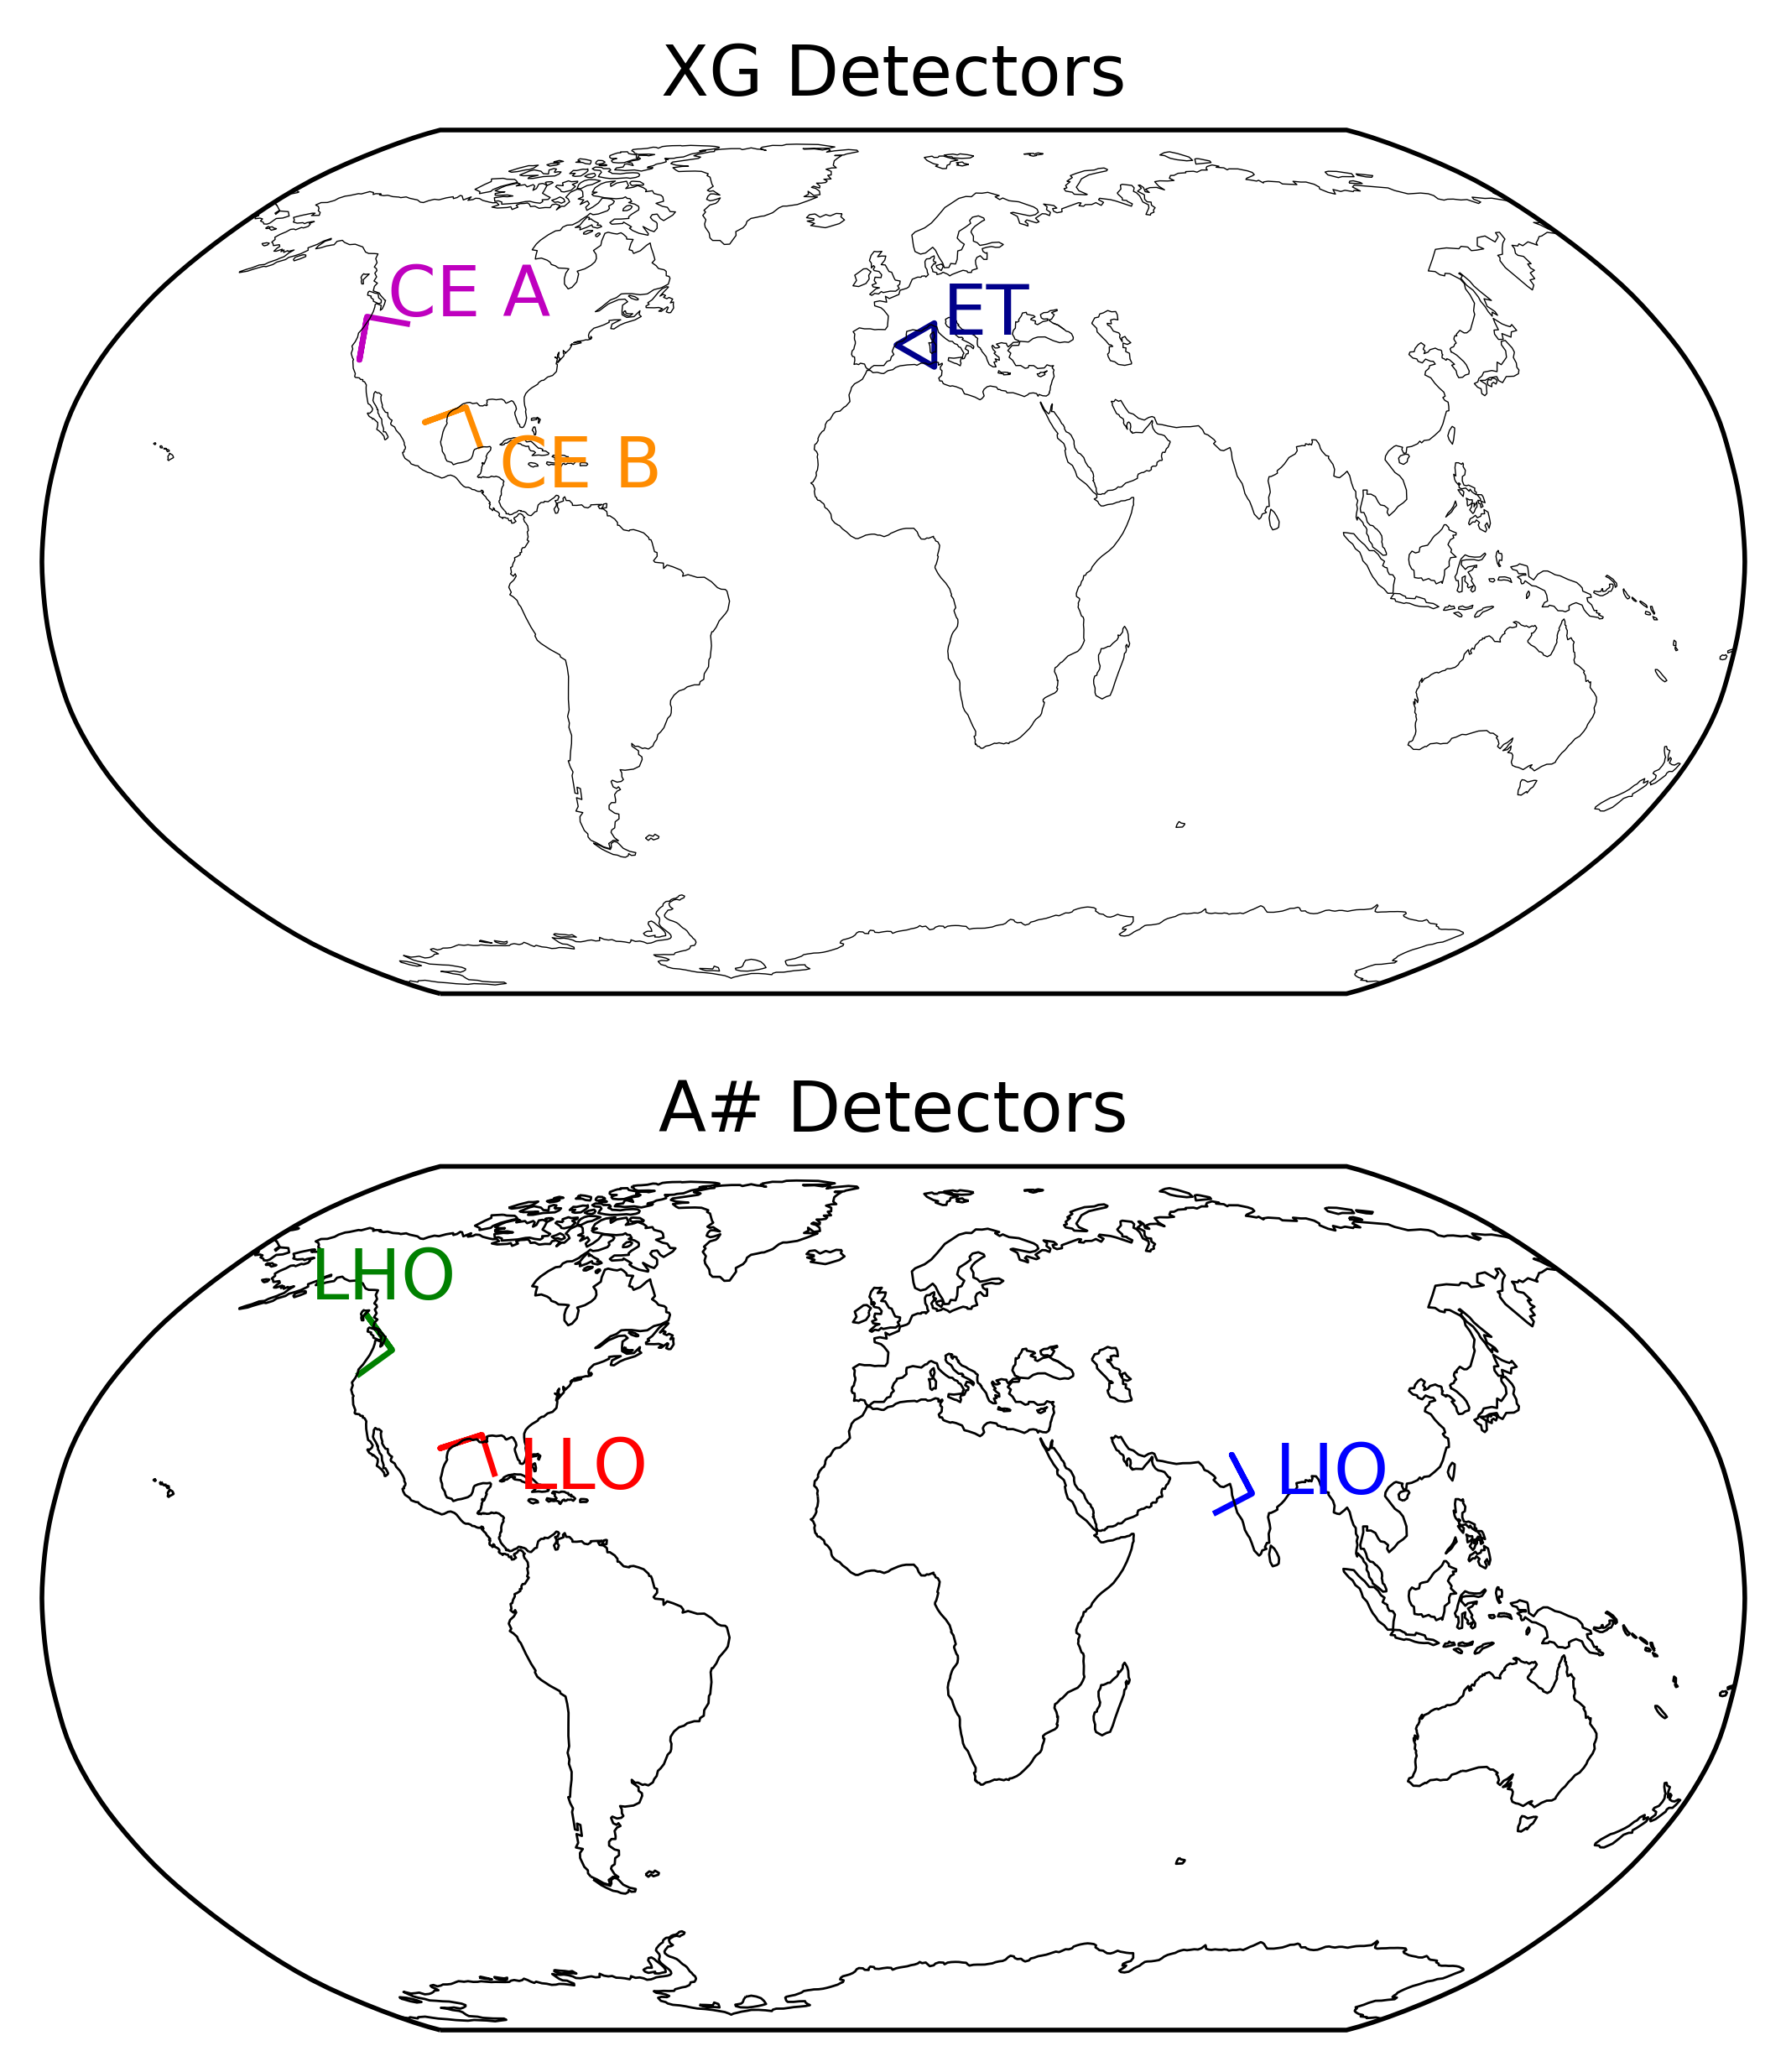

In [10]:
markersize=15
fig = plt.figure(figsize=(12,6),dpi=500)
fontsz=12
ax1 = fig.add_subplot(2, 1, 1,
                          projection=ccrs.Robinson(central_longitude=0))
ax1.set_title("XG Detectors",
              fontsize=fontsz)

mark,scale=lshaped_ifo_marker(CEA.xarm_azimuth)
ax1.scatter(CEA_longitude_deg,CEA_latitude_deg,marker=mark,color='m',s=(markersize*scale)**2, transform=ccrs.PlateCarree())
ax1.text(CEA.longitude+5,CEA.latitude,'CE A', transform=ccrs.PlateCarree(),color='m',size=fontsz)


mark,scale=lshaped_ifo_marker(CEB.xarm_azimuth)
ax1.scatter(CEB.longitude,CEB.latitude,marker=mark,color='darkorange',s=(markersize*scale)**2, transform=ccrs.PlateCarree())
ax1.text(CEB.longitude+10,CEB.latitude-15,'CE B', transform=ccrs.PlateCarree(),color='darkorange',size=fontsz)

mark,scale=tringular_ifo_marker(ET.xarm_azimuth)
ax1.scatter(ET_longitude_deg,ET_latitude_deg,marker=mark,facecolors='None',edgecolor='darkblue',s=(markersize*scale)**2, transform=ccrs.PlateCarree())
ax1.text(ETs.longitude+2,ETs.latitude+2,'ET', transform=ccrs.PlateCarree(),color='darkblue',size=fontsz)

ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.Robinson(central_longitude=0))
ax2.set_title("A# Detectors",
              fontsize=fontsz)
mark,scale=lshaped_ifo_marker(LIO_Asharp.xarm_azimuth)
ax2.scatter(LIO_Asharp.longitude,LIO_Asharp.latitude,marker=mark,color='b',s=(markersize*scale)**2, transform=ccrs.PlateCarree())
ax2.text(LIO_Asharp.longitude+5,LIO_Asharp.latitude,'LIO', transform=ccrs.PlateCarree(),color='b',size=fontsz)

mark,scale=lshaped_ifo_marker(LLO_Asharp.xarm_azimuth)
ax2.scatter(LLO_Asharp.longitude,LLO_Asharp.latitude,marker=mark,color='r',s=(markersize*scale)**2, transform=ccrs.PlateCarree())
ax2.text(LLO_Asharp.longitude+10,LLO_Asharp.latitude-10,'LLO', transform=ccrs.PlateCarree(),color='r',size=fontsz)

mark,scale=lshaped_ifo_marker(LHO_Asharp.xarm_azimuth)
ax2.scatter(LHO_Asharp.longitude,LHO_Asharp.latitude,marker=mark,color='g',s=(markersize*scale)**2, transform=ccrs.PlateCarree())
ax2.text(LHO_Asharp.longitude-30,LHO_Asharp.latitude+10,'LHO', transform=ccrs.PlateCarree(),color='g',size=fontsz)

ax2.set_global()
ax2.coastlines(linewidth=0.4)
ax1.set_global()
ax1.coastlines(linewidth=0.2)
subplots_adjust(wspace=-0.15)

ax1.grid(which='both')
savefig("detector_locations_triangET.pdf",bbox_inches='tight')


# Make ASD plot

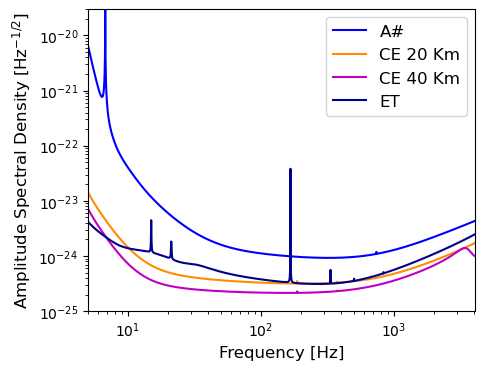

In [12]:
fig = plt.figure(figsize=(5,4),dpi=100)
plt.loglog(LIO_Asharp.power_spectral_density.frequency_array,LIO_Asharp.power_spectral_density.asd_array,label='A#',color='b')
plt.loglog(CEB.power_spectral_density.frequency_array,CEB.power_spectral_density.asd_array,label='CE 20 Km',color='darkorange')
plt.loglog(CEA.power_spectral_density.frequency_array,CEA.power_spectral_density.asd_array,label='CE 40 Km',color='m')
plt.loglog(ET.power_spectral_density.frequency_array,ET.power_spectral_density.asd_array,label='ET',color='darkblue')
legend(loc='best',fontsize=fontsz)
xlabel('Frequency [Hz]',fontsize=fontsz)
ylabel('Amplitude Spectral Density [Hz$^{-1/2}$]',fontsize=fontsz)
xlim(5,4096)
ylim(1e-25,3e-20)
savefig("asds_triangET.pdf",bbox_inches='tight')


# Examples

In [66]:
# Create a triangular 10Km ET using the PSD we provide and Bilby 
tmp=np.loadtxt('./18213_ET10kmcolumns.txt')
freqs=tmp[:,0]
PSD=tmp[:,-1]
myET=bb.gw.detector.TriangularInterferometer(name='myET',\
        power_spectral_density=psds.from_power_spectral_density_array(freqs,PSD),\
       minimum_frequency=3,maximum_frequency=8192,length=10,latitude=ET_latitude_deg,longitude=ET_longitude_deg,\
        elevation=0,xarm_azimuth=90,yarm_azimuth=150)

# Create a 40Km CE
myCEA=ifo_obj("myCEA",power_spectral_density=psds.from_amplitude_spectral_density_file('./T2000017-v6_cosmic_explorer_strain.txt'),\
             minimum_frequency=5,maximum_frequency=2048,length=40,latitude=CEA_latitude_deg,\
             longitude=CEA_longitude_deg,xarm_azimuth=CEB.xarm_azimuth+delta,yarm_azimuth=CEB.yarm_azimuth+delta,elevation=0)



In [67]:
# Check this works by calculating the SNR of a 10-10 BBH at z=1
# In particular, this shows how ET is really implemented as three detectors. 
from bilby.core.utils import logger

logger.setLevel(0)
z=1
injection_parameters={
        # These are meant to be detector frame masses, so we reshift them
        'mass_1':10*(1+z),
        'mass_2':10*(1+z),
        'theta_jn':np.pi/6,
        'psi':0,
        'phase':0,
        'dec':1,
        'ra':2,
        'phi_12':0,
        'phi_jl':0,
        'a_1':0.,
        'a_2':0,
        'tilt_1':0,
        'tilt_2':0,
        'geocent_time':1362607268,
        'redshift':z

    }
sampling_frequency = 2048.
duration=64
flow=3

for ifo in [myCEA,myET]:

    waveform_generator = bb.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bb.gw.source.lal_binary_black_hole,
    waveform_arguments=dict(reference_frequency=20., minimum_frequency=flow,
                            approximant='IMRPhenomXP'),
    parameter_conversion=bb.gw.conversion.convert_to_lal_binary_black_hole_parameters)
    waveform_generator.waveform_arguments["PhenomXPrecVersion"] = 104

    ifo.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
                                         start_time=(injection_parameters['geocent_time'] + 2 - duration))
    ifo.inject_signal(parameters=injection_parameters, waveform_generator=waveform_generator)

    if type(ifo)==bb.gw.detector.networks.TriangularInterferometer:
        for k in ifo.meta_data.keys():
            print("The snr is %.2f in IFO %s"%(ifo.meta_data[k]['optimal_SNR'],k))
    else:
        print("The snr is %.2f in IFO %s"%(ifo.meta_data['optimal_SNR'],ifo.name))

The snr is 69.21 in IFO myCEA
The snr is 40.47 in IFO myET1
The snr is 40.63 in IFO myET2
The snr is 40.19 in IFO myET3
